<a href="https://colab.research.google.com/github/boyoung21/ESAA/blob/main/1103_%ED%96%89%EB%A0%AC%EB%B6%84%ED%95%B4%EB%A5%BC_%EC%9D%B4%EC%9A%A9%ED%95%9C_%EC%9E%A0%EC%9E%AC%EC%9A%94%EC%9D%B8_%ED%98%91%EC%97%85%ED%95%84%ED%84%B0%EB%A7%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 행렬 분해를 이용한 잠재 요인 협업 필터링 실습

행렬 분해 잠재 요인 협업 필터링

- 일반적 행렬 분해에는 SVD가 자주 사용됨
- 사용자-아이템 평점 행렬에는 사용자가 평점을 매기지 않은 데이터가 많기 때문에 주로 SGD나 ALS 기반의 행렬 분해를 이용함.

In [ ]:
# 이전에 사용한 행렬 분해 rmse 코드

from sklearn.metrics import mean_squared_error

def get_rmse(R, P, Q, non_zeros):
  error = 0
  full_pred_matrix = np.dot(P, Q.T)

  x_non_zero_ind = [non_zero[0] for non_zero in non_zeros]
  y_non_zero_ind = [non_zero[1] for non_zero in non_zeros]
  R_non_zeros = R[x_non_zero_ind, y_non_zero_ind]
  full_pred_matrix_non_zeros = full_pred_matrix[x_non_zero_ind, y_non_zero_ind]
  mse = mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros)
  rmse = np.sqrt(mse)

  return rmse

In [ ]:
def matrix_factorization(R, K, steps = 200, learning_rate = 0.01, r_lambda = 0.01):
  num_users, num_items = R.shape
  # P와 Q 매트릭스의 크기를 지정하고 정규 분포를 가진 랜덤한 값으로 입력합니다.
  np.random.seed(1)
  P = np.random.normal(scale = 1./K, size = (num_users, K))
  Q = np.random.normal(scale = 1./K, size = (num_items, K))

  # R > 0 인 행 위치, 열 위치, 값을 non-zeros 리스트 객체에 저장
  non_zeros = [(i, j, R[i, j]) for i in range(num_users) for j in range(num_items) if R[i, j] > 0 ]

  # SGD 기법으로 P와 Q 매트릭스를 계속 업데이트.
  for step in range(steps):
    for i, j, r in non_zeros:
      # 실제 값과 예측 값의 차이인 오류 값 구함
      eij = r - np.dot(P[i,:], Q[j,:].T)
      # Regularization을 반영한 SGD 업데이트 공식 적용
      P[i, :] = P[i,:] + learning_rate*(eij * Q[j,:] - r_lambda*P[i,:])
      Q[j, :] = Q[j,:] + learning_rate*(eij*P[i,:]- r_lambda*Q[j,:])

    rmse = get_rmse(R,P,Q,non_zeros)
    if (step % 10) == 0:
      print("### iteration step : ", step, " rmse : ", rmse)

  return P, Q
#

In [ ]:
import pandas as pd
import numpy as np

movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
ratings = ratings[['userId', 'movieId', 'rating']]
ratings_matrix = ratings.pivot_table('rating', index = 'userId', columns = 'movieId')

# title 칼럼을 얻기 위해 movies와 조인 수행
rating_movies = pd.merge(ratings, movies, on = 'movieId')

#columns = 'title로로 title 칼럼으로 pivot 수행
ratings_matrix = rating_movies.pivot_table('rating', index = 'userId', columns = 'title')

In [ ]:
# 다시 만들어진 사용자-아이템 평점 행렬을 matrix_factorization() 함수를 이용해 행렬 분해

P, Q = matrix_factorization(ratings_matrix.values, K=50, steps = 200, learning_rate = 0.01, r_lambda = 0.01)
pred_matrix = np.dot(P, Q.T)

### iteration step :  0  rmse :  2.9023619751336867
### iteration step :  10  rmse :  0.7335768591017927
### iteration step :  20  rmse :  0.5115539026853442
### iteration step :  30  rmse :  0.37261628282537446
### iteration step :  40  rmse :  0.2960818299181014
### iteration step :  50  rmse :  0.2520353192341642
### iteration step :  60  rmse :  0.22487503275269854
### iteration step :  70  rmse :  0.2068545530233154
### iteration step :  80  rmse :  0.19413418783028685
### iteration step :  90  rmse :  0.18470082002720406
### iteration step :  100  rmse :  0.17742927527209104
### iteration step :  110  rmse :  0.1716522696470749
### iteration step :  120  rmse :  0.16695181946871726
### iteration step :  130  rmse :  0.16305292191997542
### iteration step :  140  rmse :  0.15976691929679646
### iteration step :  150  rmse :  0.1569598699945732
### iteration step :  160  rmse :  0.15453398186715425
### iteration step :  170  rmse :  0.15241618551077643
### iteration step :  180  rm

In [ ]:
# 영화 타이틀을 칼럼명으로 가지는 DF로 변경

ratings_pred_matrix = pd.DataFrame(data = pred_matrix, index = ratings_matrix.index, columns = ratings_matrix.columns)
ratings_pred_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,3.055084,4.092018,3.564130,4.502167,3.981215,1.271694,3.603274,2.333266,5.091749,3.972454,...,1.402608,4.208382,3.705957,2.720514,2.787331,3.475076,3.253458,2.161087,4.010495,0.859474
2,3.170119,3.657992,3.308707,4.166521,4.311890,1.275469,4.237972,1.900366,3.392859,3.647421,...,0.973811,3.528264,3.361532,2.672535,2.404456,4.232789,2.911602,1.634576,4.135735,0.725684
3,2.307073,1.658853,1.443538,2.208859,2.229486,0.780760,1.997043,0.924908,2.970700,2.551446,...,0.520354,1.709494,2.281596,1.782833,1.635173,1.323276,2.887580,1.042618,2.293890,0.396941


## 만들어진 예측 사용자-아이템 평점 행렬 정보를 이용해 개인화된 영화 추천
사용자 아이디 9번에 대한 영화 추천을 이번에는 잠재 요인 협업 필터링으로 추천

In [ ]:
# 이전에 생성했던 get_unseen_movies() 이용
def get_unseen_movies(ratings_matrix, userId):
  user_rating = ratings_matrix.loc[userId, :]

  already_seen = user_rating[user_rating > 0].index.tolist()
  movies_list = ratings_matrix.columns.tolist()
  unseen_list = [movie for movie in movies_list if movie not in already_seen]

  return unseen_list

In [ ]:
# 이전에 사용한 데이터 유사도에 기반한 예측 평점 데이터 세트를 이용해 최종적으로 사용자에게 영화를 추천하는 함수
def recomm_movie_by_userid(pred_df, userId, unseen_list, top_n = 10):
  recomm_movies = pred_df.loc[userId, unseen_list].sort_values(ascending = False)[:top_n]
  return recomm_movies

In [ ]:
# 사용자가 관람하지 않은 영화명 추출
unseen_list = get_unseen_movies(ratings_matrix, 9)

# 잠재 요인 협업 필터링으로 영화 추천
recomm_movies = recomm_movie_by_userid(ratings_pred_matrix, 9, unseen_list, top_n = 10)

# 평점 데이터를 DataFrame으로 생성
recomm_movies = pd.DataFrame(data = recomm_movies.values, index = recomm_movies.index,
                             columns = ['pred_score'])
recomm_movies

,pred_score
title,
Rear Window (1954),5.704612
"South Park: Bigger, Longer and Uncut (1999)",5.451100
Rounders (1998),5.298393
Blade Runner (1982),5.244951
Roger & Me (1989),5.191962
Gattaca (1997),5.183179
Ben-Hur (1959),5.130463
Rosencrantz and Guildenstern Are Dead (1990),5.087375
"Big Lebowski, The (1998)",5.038690


앞절에 추천된 영화 목록과는 상이한 결과임을 알 수 있음. 전반적으로 무거운 주제의 영화들.

# 파이썬 추천 시스템 패키지 - Surprise

파이썬 기반의 추천 시스템 구축을 위한 전용 패키지로, 사이킷런과 유사한 API와 프레임워크를 제공.

In [2]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 4.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp312-cp312-linux_x86_64.whl size=2611206 sha256=bedd490d91ec3d67230528331b8dfb96ccf58e54cbda82fdc39a8c696e57e5ee
  Stored in directory: /root/.cache/pip/wheels/75/fa/bc/739bc2cb1fbaab6061854e6cfbb81a0ae52c92a502a7fa454b
Successfully built scikit-surprise


In [1]:
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split

Surprise는 주요 데이터가 row 레벨 형태로 처리돼 있는 포맷의 데이터만 처리함. 또, Dataset 클래스를 이용해서만 데이터 로딩이 가능

In [ ]:
data = Dataset.load_builtin('ml-100k')
# 수행 시마다 동일하게 데이터를 분할하기 위해 random_state 값 부여
trainset, testset = train_test_split(data, test_size = 25, random_state = 0)

Dataset ml-100k could not be found. Do you want to download it? [Y/n] Y
Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


해당 데이터 세트를 적용할 때 주의할 점은, 로우 레벨의 사용자-아이템 평점 데이터를 그대로 적용해야 한다는 것. 앞에서는 로우 레벨의 사용자-아이템 평점 데이터를 아이템 아이디를 칼럼명으로 변환한 형태의 사용자-아이템 평점 행렬 데이터로 변환함. Surprise는 자체적으로 로우 레벨의 데이터를 칼럼 레벨의 데이터로 변경하므로 원본을 적용해야 함.

# SVD로 잠재 요인 협업 필터링 수행

In [ ]:
# 학습 데이터 세트 기반으로 추천 알고리즘 학습
algo = SVD(random_state = 0)
algo.fit(trainset)

Surprise에서 추천을 예측하는 메서드는 test(), predict() 두 개.

- test(): 사용자-아이템 평점 데이터 세트 전체에 대해서 추천을 예측하는 메서드. 즉, 입력된 데이터 세트에 대해 추천 데이터 세트를 만들어 줌
> 메서드 호출 결과: list

  > 출력 결과의 크기는 입력 인제 데이터 세트의 크기와 같은 25,00개
  
  > was_impossible이 True이면 예측값을 생성할 수 없는 데이터라는 의미
- predict(): 개별 사용자와 영화에 대한 추천 평점을 반환해 줌.

In [ ]:
predictions = algo.test(testset)
print('prediction type: ', type(predictions), 'size: ', len(predictions))
print('prediction 결과의 최조 5개 추출')
predictions[:5]

prediction type:  <class 'list'> size:  25
prediction 결과의 최조 5개 추출


[Prediction(uid='917', iid='50', r_ui=3.0, est=4.149217910133892, details={'was_impossible': False}),
 Prediction(uid='235', iid='318', r_ui=5.0, est=4.333029650171127, details={'was_impossible': False}),
 Prediction(uid='339', iid='12', r_ui=5.0, est=4.652894591303144, details={'was_impossible': False}),
 Prediction(uid='878', iid='755', r_ui=2.0, est=2.7545011408291202, details={'was_impossible': False}),
 Prediction(uid='618', iid='56', r_ui=4.0, est=3.021383823173283, details={'was_impossible': False})]

In [ ]:
[(pred.uid, pred.iid, pred.est) for pred in predictions[:3]]

[('917', '50', 4.149217910133892),
 ('235', '318', 4.333029650171127),
 ('339', '12', 4.652894591303144)]

In [ ]:
# predict()를 이용해 추천 예측
# 사용자 아이디, 아이템 아이디는 문자열로 입력해야 함
uid = str(196)
iid = str(302)
pred = algo.predict(uid, iid)
print(pred)

user: 196        item: 302        r_ui = None   est = 4.37   {'was_impossible': False}


In [ ]:
accuracy.rmse(predictions)

RMSE: 0.9277


0.9277328494227115

# Surprise 주요 모듈 소개

Suprise는 user_id, item_id, rating 데이터가 로우 레벨로, 즉 칼럼으로 할당된 된 데이터 세트에만 적용 가능. 네 번째 칼럼부터는 로딩 수행을 하지 않음.

In [9]:
# os 파일 데이터를 surprise 데이터 세트로 로딩
# 주의사항: 칼럼명을 가지는 헤더 문자열이 있어선 안 됨

import pandas as pd
ratings = pd.read_csv('ratings.csv')
# ratings_noh.csv 파일로 언로드 시 인덱스와 헤더를 모두 제거한 새로운 파일 생성.
ratings.to_csv('ratings_noh.csv', index = False, header = False)

In [10]:
from surprise import Reader

reader = Reader(line_format = 'user item rating timestamp', sep = ',', rating_scale=(0.5, 5))
data = Dataset.load_from_file('ratings_noh.csv', reader = reader)

reader 클래스의 주요 생성 파라미터
- line_format(string): 칼럼을 순서대로 나열함. 입력된 문자열을 공백으로 분리해 칼럼으로 인식
- sep(char): 칼럼을 분리하는 분리자이며, 디폴트는 '\t'
- rating_scale (tuple, optional): 평점값의 최소~최대 평점을 설정, 디폴트는 (1,5)

In [ ]:
# 잠재요인 K -> n_factors

trainset, testset = train_test_split(data, test_size = 0.25, random_state = 0)

# 수행 시마다 동일한 결과를 도출하기 위해 random_state 설정
algo = SVD(n_factors=50, random_state=0)

# 학습 데이터 세트로 학습하고 나서 테스트 데이터 세트로 평점 예측 후 RMSE 평가
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.8682


0.8681952927143516

# 판다스 DataFrame에서 Surprise 데이터 세트로 로딩

마찬가지로 사용자 아이디, 아이템 아이디, 평점 칼럼 순서를 지켜야 함.

In [ ]:
import pandas as pd
from surprise import Reader, Dataset

ratings = pd.read_csv('ratings.csv')
reader = Reader(rating_scale=(0.5, 5.0))

# ratings DataFrame에서 칼럼은 사용자 아이디, 아이템 아이디, 평점 순서를 지켜야 합니다.
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size = .25, random_state = 0)

algo = SVD(n_factors = 50, random_state = 0)
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.8682


0.8681952927143516

# Surprise 추천 알고리즘 클래스

- SVD: 행렬 분해를 통한 잠재 요인 협업 필터링을 위한 SVD 알고리즘.
> 비용함수는 베이스라인 편향성을 감안한 평점 예측에 Regularization을 적용한 것.

  > 입력 파라미터는 n_factors(잠재 요인 k의 개수로 디폴트 100, 높을수록 정확도와 과적합 가능성 증가), n_epochs(반복횟수, 디폴트 20), biased (bool, 베이스라인 편향 적용 여부로 디폴트 True)이 있음
- KNNBAsic: 최근접 이웃 협업 필터링을 위한 KNN 알고리즘
- BaselineOnly: 사용자 Bias와 아이템 Bias를 감안한 SGD 베이스라인 알고리즘.

이 외에도 다양한 유형의 알고리즘 존재.

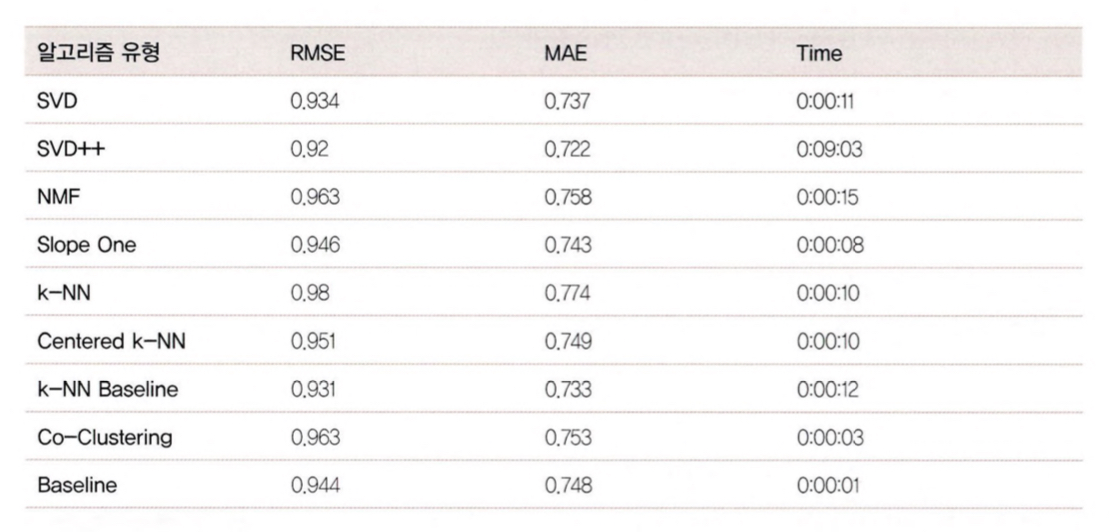


SVD++ 알고리즘의 성적이 가장 좋지만 시간이 너무 오래 걸려 데이터가 조금만 커져도 사용하기 어려움. knn 자체는 성능이 상대적으로 좋지 않지만, 베이스라인을 결합한 경우 성능 평가 수치가 향상됨을 보임. 베이스라인은 개인이 평점을 부여하는 성향을 반영해 평점을 계산하는 방식

예## 베이스라인 평점

개인의 성향, 즉 편향성 요소를 반영하여 평점을 부과하는 것을 의미함.
보통 베이스라인 평점은 전체 평균 평점 + 사용자 편향 점수 + 아이템 편향 점수 공식으로 계산됨.

- 전체 평균 평점: 모든 사용자의 아이템에 대한 평점을 평균한 값
- 사용자 편향 점수 = 사용자별 아이템 평점 평균 값 - 전체 평균 평점
- 아이템 편향 점수 = 아이템별 평점 평균 값 - 전체 평균 평점

예시를 적용하면 다음과 같음
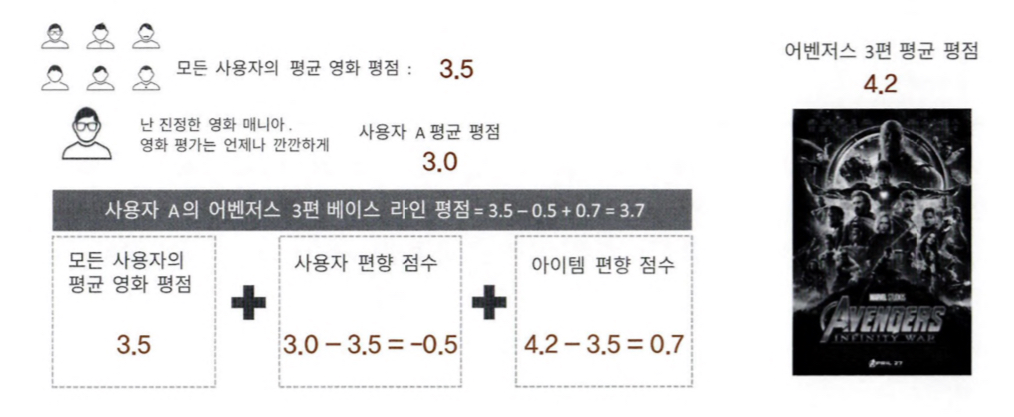



## 교차 검증과 하이퍼 파라미터 튜닝

Surprise는 교차 검증과 하이퍼 파라미터 튜닝을 위해 사이킷런과 유사한 cross_validate(), GridSearchCV 클래스를 제공함.

In [4]:
# cross_validate() 사용
from surprise.model_selection import cross_validate

# 판다스 DataFrame에서 Surprise 데이터 세트로 데이터 로딩
ratings = pd.read_csv('ratings.csv') # reading data in pandas df
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

algo = SVD(random_state=0)
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8682  0.8758  0.8734  0.8824  0.8761  0.8752  0.0046  
MAE (testset)     0.6684  0.6737  0.6708  0.6766  0.6734  0.6726  0.0028  
Fit time          1.69    1.47    1.49    1.47    1.59    1.54    0.09    
Test time         0.12    0.12    0.21    0.11    0.23    0.16    0.05    


{'test_rmse': array([0.86823655, 0.87581817, 0.87342352, 0.88237865, 0.87605224]),
 'test_mae': array([0.66835567, 0.67372245, 0.67082294, 0.67659116, 0.67344381]),
 'fit_time': (1.6937251091003418,
  1.465759038925171,
  1.494065523147583,
  1.4733445644378662,
  1.5944650173187256),
 'test_time': (0.12177395820617676,
  0.11502289772033691,
  0.2053380012512207,
  0.11304783821105957,
  0.22864699363708496)}

In [6]:
# GridSearchCV
from surprise.model_selection import GridSearchCV

# 최적화할 파라미터를 딕셔너리 형태로 지정.
param_grid = {'n_epochs': [20, 40, 60], 'n_factors': [50, 100, 200]}

# CV를 3개 폴드 세트로 지정, 성능 평가는 rmse, mse로 수행하도록 GridSearchCV 구성
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

# 최고 RMSE Evaluation 점수와 그때의 하이퍼 파라미터
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.8770536783905142
{'n_epochs': 20, 'n_factors': 50}


# Surprise를 이용한 개인화 영화 추천 시스템 구축

Surprise 패키지로 학습된 추천 알고리즘을 기반으로 특정 사용자가 아직 평점을 매기지 않은(관람하지 않은) 영화 중에서 개인 취향에 가장 적절한 영화를 추천하는 시스템 구축

- 이번 예제에서는 데이터를 학습 / 테스트로 나누지 않고 전체 데이터를 학습 데이터로 사용
- 그러나 train_test_split을 이용해 내부에서 사용하는 TrainSet 클래스 객체로 변환하지 않으면 fit()으로 학습을 진행할 수 없어서 오류 발생

In [7]:
# 다음 코드는 train_test_split()으로 분리되지 않은 데이터 세트에 fit()을 호출해 오류 발생
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
algo = SVD(n_factors=50, random_state=0)
algo.fit(data)

AttributeError: 'DatasetAutoFolds' object has no attribute 'n_users'

데이터 세트 전체를 학습 데이터로 사용하려면 DatasetAutoFolds 클래스를 이용하면 됨

DatasetAutoFolds 객체를 생성한 뒤에 build_full_trainset() 메서드를 호출하면 전체 데이터를 학습 데이터 세트로 만들 수 있음

In [11]:
from surprise.dataset import DatasetAutoFolds

reader = Reader(line_format='user item rating timestamp', sep=',', rating_scale=(0.5, 5))
# DatasetAutoFolds 클래스를 ratings_noh.csv 파일 기반으로 생성.
data_folds = DatasetAutoFolds(ratings_file='ratings_noh.csv', reader=reader)

# 전체 데이터를 학습 데이터로 생성함.
trainset = data_folds.build_full_trainset()

In [12]:
# 학습 수행
algo = SVD(n_epochs=20, n_factors=50, random_state=0)
algo.fit(trainset)

In [13]:
# 영화에 대한 상세 속성 정보 DataFrame 로딩
movies = pd.read_csv('movies.csv')

# userId=9의 movieId 데이터를 추출해 movieId=42 데이터가 있는지 확인
movieIds = ratings[ratings['userId']==9]['movieId']
if movieIds[movieIds==42].count() == 0:
  print('사용자 아이디 9는 영화 아이디 42의 평점 없음')

print(movies[movies['movieId']==42])

사용자 아이디 9는 영화 아이디 42의 평점 없음
    movieId                   title              genres
38       42  Dead Presidents (1995)  Action|Crime|Drama


In [14]:
# 추천 예상 평점 -> predict() 메서드 이용
# 무조건 문자열 입력해 줘야 함
uid = str(9)
iid = str(42)

pred = algo.predict(uid, iid, verbose=True)

user: 9          item: 42         r_ui = None   est = 3.13   {'was_impossible': False}


In [16]:
# 사용자가 평점 안 매긴 영화 전체를 추출 뒤 예측 평점 순으로 추천
def get_unseen_surprise(ratings, movies, userId):
  # 입력값으로 들어온 userId에 해당하는 사용자가 평점을 매긴 모든 영화를 리스트로 생성
  seen_movies = ratings[ratings['userId'] == userId]['movieId'].tolist()
  # 모든 영화의 movieId를 리스트로 생성.
  total_movies = movies['movieId'].tolist()
  # 모든 영화의 movieId 중 이미 평점을 매긴 영화의 movieId를 제외한 후 리스트로 생성
  unseen_movies = [movie for movie in total_movies if movie not in seen_movies]
  print('평점 매긴 영화 수:', len(seen_movies), '추천 대상 영화 수:', len(unseen_movies), '전체 영화 수:', len(total_movies))

  return unseen_movies

unseen_movies = get_unseen_surprise(ratings, movies, 9)

평점 매긴 영화 수: 46 추천 대상 영화 수: 9696 전체 영화 수: 9742


In [17]:
def recomm_movie_by_surprise(algo, userId, unseen_movies, top_n = 10):

  # 알고리즘 객체의 predict() 메서드를 평점이 없는 영화에 반복 수행한 후 결과를 list 객체로 저장
  predictions = [algo.predict(str(userId), str(movieId)) for movieId in unseen_movies]

  # predictions list 객체는 surprise의 Predictions 객체를 원소로 가지고 있음.
  # [Prediction(uid='9', iid = '1', est=3.69), Prediction(uid='9', iid='2', est = 2.98),,,]

  # 이를 est 값으로 정렬하기 위해서 아래의 sortkey_est 함수를 정의함
  # sortkey_est 함수는 list 객체의 sort() 함수의 키 값으로 사용되어 정렬 수행.
  def sortkey_est(pred):
    return pred.est
  # sortkey_est() 반환값의 내림 차순으로 정렬 수행하고 top_n개의 최상위 값 추출
  predictions.sort(key=sortkey_est, reverse=True)
  top_predictions = predictions[:top_n]

  # top_n으로 추출된 영화의 정보 추출, 영화 아이디, 추천 예상 평점, 제목 추출
  top_movie_ids = [int(pred.iid) for pred in top_predictions]
  top_movie_rating = [pred.est for pred in top_predictions]
  top_movie_titles = movies[movies.movieId.isin(top_movie_ids)]['title']

  top_movie_preds = [(id, title, rating) for id, title, rating in \
                     zip(top_movie_ids, top_movie_titles, top_movie_rating)]

  return top_movie_preds


unseen_movies = get_unseen_surprise(ratings, movies, 9)
top_movie_preds = recomm_movie_by_surprise(algo, 9, unseen_movies, top_n = 10)

print('##### Top-10 추천 영화 리스트 #####')
for top_movie in top_movie_preds:
  print(top_movie[1], ":", top_movie[2])

평점 매긴 영화 수: 46 추천 대상 영화 수: 9696 전체 영화 수: 9742
##### Top-10 추천 영화 리스트 #####
Usual Suspects, The (1995) : 4.306302135700814
Star Wars: Episode IV - A New Hope (1977) : 4.281663842987387
Pulp Fiction (1994) : 4.278152632122759
Silence of the Lambs, The (1991) : 4.226073566460876
Godfather, The (1972) : 4.1918097904381995
Streetcar Named Desire, A (1951) : 4.154746591122657
Star Wars: Episode V - The Empire Strikes Back (1980) : 4.122016128534504
Star Wars: Episode VI - Return of the Jedi (1983) : 4.108009609093436
Goodfellas (1990) : 4.083464936588478
Glory (1989) : 4.07887165526957
